Easy to read article about calibration: http://fastml.com/classifier-calibration-with-platts-scaling-and-isotonic-regression/

In [110]:
import FairBoost
from FairBoost import FairBoostRegressor
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
from sklearn import datasets
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import *
#from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import FairBoostRegressor
#from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold
%matplotlib inline
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

In [111]:
#load data
X = pickle.load( open( "x.p", "rb" ) )
y = pickle.load( open( "y.p", "rb" ) )
g = pickle.load( open( "g.p", "rb" ) )
g=np.nan_to_num(g)
g0 = np.nan_to_num([i for i,x in enumerate(g) if x==0])
g1 = np.nan_to_num([i for i,x in enumerate(g) if x==1])

In [112]:


# fbt = FairBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=1, random_state=25)
# fbt.setGroups(g)

# fbt.fit(X,y)
# train_pred = fbt.predict(X)
# print('train error iteration 1 ', mean_squared_error(train_pred, y))

# fbt = FairBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=10, random_state=25)
# fbt.setGroups(g)

# fbt.fit(X,y)
# train_pred = fbt.predict(X)
# print('train error iteration 10 ', mean_squared_error(train_pred, y))

In [129]:
#Error metrics

#summary of deviation measures - relates to precision/accuracy?
# https://en.wikipedia.org/wiki/Deviation_(statistics)#Unsigned_or_absolute_deviation
#https://en.wikipedia.org/wiki/Mean_signed_deviation
#signed absolute deviation ?
# https://en.wikipedia.org/wiki/Average_absolute_deviation
#average absolute deviation

def get_ae(vals):
    return np.sum([math.fabs(x[0]-x[1]) for x in vals])

def get_mae(vals):
    m = np.sum([math.fabs(x[0]-x[1]) for x in vals])
    return m/len(vals)


def get_se(vals):
    return np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    
def get_mse(vals):
    m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    return m/len(vals)

#overestimate
def get_oe(vals):
    return np.sum([max(0,x[0]-x[1]) for x in vals])

def get_moe(vals):
    m = np.sum([max(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

#underestimate
def get_ue(vals):
    return np.sum([min(0,x[0]-x[1]) for x in vals])

def get_mue(vals):
    m = np.sum([min(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

error_functs = [get_ae, get_mae, get_se, get_mse, get_oe, get_moe, get_ue, get_mue]
##### BIN ERRORS: ###########

def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)

def get_error_binned_eq_depth_by_group(points, nbins, error=get_mse):
    mse = []
    kf = KFold(len(points), n_folds=nbins, shuffle=True, random_state=1)
    for rest, bin in kf:
        vals = [points.iloc[i] for i in bin]
        mse.append(error(vals))
    return mse

# I guess Python changed the syntax of the KFold function at some point???
def get_error_binned_eq_depth_by_group2(points, nbins, error=get_mse):
    mse = []
    kf = KFold(n_splits=nbins, shuffle=True, random_state=1)
    for rest, bin in kf.split(points):
        vals = [points.iloc[i] for i in bin]
        mse.append(error(vals))
    return mse

def plot_binned_error(df, error=get_mse):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df[df.columns[0]],width,color='b',label='-Ymin')
    ax.bar(indices,df[df.columns[1]],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=len(df))
    ax.set_ylim([0,1])
    ax.set_xlabel('Bin')
    ax.set_ylabel(error.__name__)
    plt.show()
    
def recomputeBins(y_predict, g0, g1, nbins):
        #g0 has indexes of objects in X
        # get indexes of sorted predictions for group
        sorted0 = np.argsort([y_predict[x] for x in g0])
        binSize=int(np.ceil(float(len(g0))/nbins))
        bins0=[]
        b=[]
        i=0
        j=binSize-1
        for n in range(nbins):
            k=int(min(j,len(sorted0)-1))
            bins0.append([g0[x] for x in sorted0[i:k]])
            i+=binSize
            j+=binSize
           
        #g1 has indexes of objects in X
        # get indexes of sorted predictions for group
        sorted1 = np.argsort([y_predict[x] for x in g1])
        binSize=int(np.ceil(float(len(g1))/nbins))
        bins1=[]
        b=[]
        i=0
        j=binSize-1
        for n in range(nbins):
            k=int(min(j,len(sorted0)-1))
            bins1.append([g1[x] for x in sorted1[i:k]])
            i+=binSize
            j+=binSize
        return bins0,bins1

In [130]:
# lr = linear_model.LinearRegression()
# dt = DecisionTreeRegressor(max_depth=4)
# clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')

In [131]:
# y

In [132]:
# Randomly assigns observations into train, calibration, and test groups. 
# Should probably be done with something like KFold
#kf = KFold(n_splits=2, shuffle=True, random_state=1)
#nbins = 10



# X.shape: x is 142 rows with 440 attributes
# y.shape: y is 142 rows long

# Split data into three groups: train, calibrate, and test
# Make a random list of numbers from 1 to X.length 
from random import shuffle

obs = list(range(0,len(X))) #0 to len(X), array positions
shuffle(obs)
obs

#Grab 25% for train, 25% for calibrate, and rest for test
import math
n_train = math.floor(len(X)*0.25) #25% of the observations are training
n_calibrate = math.floor(len(X)*0.25) #25% are calibration

#X attributes
x_train = X[[obs[0:n_train]]] # training dataset
x_calibrate = X[[obs[n_train:n_train+n_calibrate]]] # calibration dataset
x_test = X[[obs[n_train+n_calibrate:len(X)]]] # test dataset

#assert that split dataset is still the same size as original and no rows were duplicated
assert np.vstack({tuple(row) for row in np.r_[x_train,x_calibrate,x_test]}).shape == X.shape

# Do the same with y labels
y_train = y[obs[0:n_train]] # training dataset
y_calibrate = y[obs[n_train:n_train+n_calibrate]] # calibration dataset
y_test = y[obs[n_train+n_calibrate:len(y)]] # test dataset
assert np.r_[y_train,y_calibrate,y_test].shape == y.shape #same shape, not good idea to check for unique

# Do the same thing with g
g_train = g[obs[0:n_train]] # training dataset
g_calibrate = g[obs[n_train:n_train+n_calibrate]] # calibration dataset
g_test = g[obs[n_train+n_calibrate:len(g)]] # test dataset
assert np.r_[g_train,g_calibrate,g_test].shape == g.shape #same shape, not good idea to check for unique

In [133]:
# Learn a linear model on the training data
lr = linear_model.LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [134]:
# Baseline using test data
y_hat_test_baseline = lr.predict(x_test) # returns y_hat_test

In [135]:
# Calibration model for training isotonic regression
y_hat_calibrate = lr.predict(x_calibrate) # returns y_hat_calibrate

In [136]:
# Fit an isotonic regression on y_hat_calibrate and y_calibrate
ir = IsotonicRegression( out_of_bounds = 'clip' )
ir.fit(y_hat_calibrate, y_calibrate)

IsotonicRegression(increasing=True, out_of_bounds='clip', y_max=None,
          y_min=None)

In [137]:
# Calibrated error using test data
y_hat_test_calibrate = ir.transform(y_hat_test_baseline)   # or ir.fit( p_test ), that's the same thing

In [138]:
# Normalized
# (y - min(y)) / (max(y)-min(y))

group0:  (41, 3)
group1:  (31, 3)


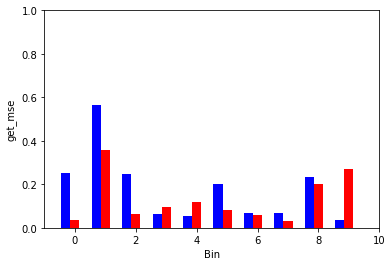

In [139]:
nbins = 10

### PLOTTING ###
results = pd.DataFrame()
results['pred'] = y_hat_test_calibrate
results['y'] = y_test
results['g'] = g_test
results = results.sort_values('pred')
results0 = results[results['g']==0]
print ("group0: ", results0.shape)
results1 = results[results['g']==1]
print ("group1: ", results1.shape)

mse_df_depth = pd.DataFrame()
mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group2(results0, nbins, error=get_mse)
mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group2(results1, nbins, error=get_mse)
plot_binned_error(mse_df_depth)

In [125]:
#kf = KFold(n_splits=2, shuffle=True, random_state=1)

#nbins = 10

In [126]:
# for train_index, test_index, in kf.split(X):
#     dt = DecisionTreeRegressor(max_depth=4)
#     dt.fit(X[train_index],y[train_index])
#     dt_pred = dt.predict(X[test_index])
#     clf_isotonic = CalibratedRegressor(dt, cv="prefit", method='isotonic')
#     clf_isotonic.fit(X[train_index], y[train_index])
#     prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]
#     print('\n decision tree error: ', mean_squared_error(dt_pred, y[test_index]))

#     g0 = [i for i,x in enumerate(g[test_index]) if x==0]
#     g1 = [i for i,x in enumerate(g[test_index]) if x==1]
#     bins0,bins1  = recomputeBins(dt_pred, g0, g1, nbins)
#     error_vect=np.abs(dt_pred - y[test_index])
#     e0=[np.sum([error_vect[i] for i in b]) for b in bins0]
#     e1=[np.sum([error_vect[i] for i in b]) for b in bins1]
#     bin_error = np.subtract(e0, e1)
#     print("dt fair error: ", np.mean(np.abs(bin_error)))

#     ### PLOTTING ###
#     results = pd.DataFrame()
#     results['pred'] = dt_pred
#     results['y'] = y[test_index]
#     results['g'] = g[test_index]
#     results = results.sort_values('pred')
#     results0 = results[results['g']==0]
#     print ("group0: ", results0.shape)
#     results1 = results[results['g']==1]
#     print ("group1: ", results1.shape)

#     mse_df_depth = pd.DataFrame()
#     mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=get_mse)
#     mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=get_mse)
#     plot_binned_error(mse_df_depth)

TODO:
    Not producing any consistent results
    Try different ways of updating the weights bin-wise
    is error being computed as mse? investigate error_vect
    read up on non-differentiable error in boosting. Are we just jumping around?
    try plotting change in bin_error over iterations

In [128]:
#results['pred']